<a href="https://colab.research.google.com/github/afauzan14/imdb-sentiment-rnn-vs-lstm/blob/main/Code_UAS_NLP_Kelompok1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Kelompok 1**
| Nama | NIM |
| -------- | -------- |
| Ahmad Fauzan | 11220940000031|
| Fadhilah Awal Rizqiansyah | 11220940000064|

#Import library

In [ ]:
!pip install tensorflow
# Import library
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import re
from collections import Counter

#Load Data

In [ ]:
# Load dataset
url = 'https://drive.google.com/uc?id=1HBMq_rRu9WDyDVhyoBXM6JHJU3vewZFM&export=download'
df = pd.read_csv(url)
texts = df['review'].values
labels = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values

In [ ]:
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


# EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df['sentiment'] = df['sentiment'].astype("category")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   review     50000 non-null  object  
 1   sentiment  50000 non-null  category
dtypes: category(1), object(1)
memory usage: 439.7+ KB
None


In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
negative,25000
positive,25000


In [ ]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


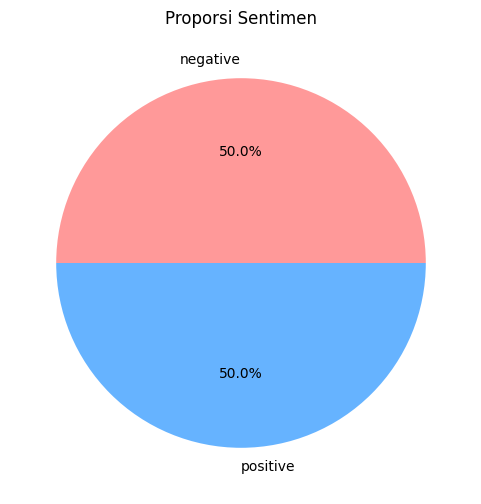

In [ ]:
# Hitung frekuensi label
sentiment_counts = df['sentiment'].value_counts()

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['#FF9999','#66B3FF'])
plt.title('Proporsi Sentimen')
plt.show()

In [ ]:
# Ukuran karakter per review
df['char_count'] = df['review'].str.len()

# Ukuran kata per review
df['word_count'] = df['review'].str.split().apply(len)

# Tampilkan ringkasan statistik
print(df[['char_count', 'word_count']].describe())

         char_count    word_count
count  50000.000000  50000.000000
mean    1309.431020    231.156940
std      989.728014    171.343997
min       32.000000      4.000000
25%      699.000000    126.000000
50%      970.000000    173.000000
75%     1590.250000    280.000000
max    13704.000000   2470.000000


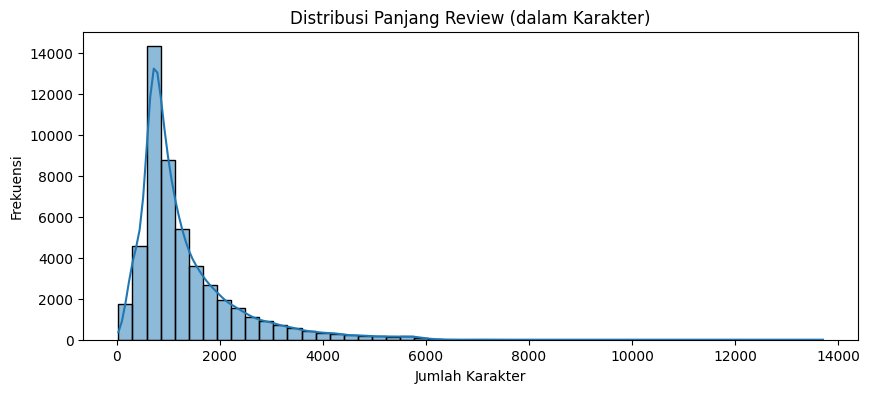

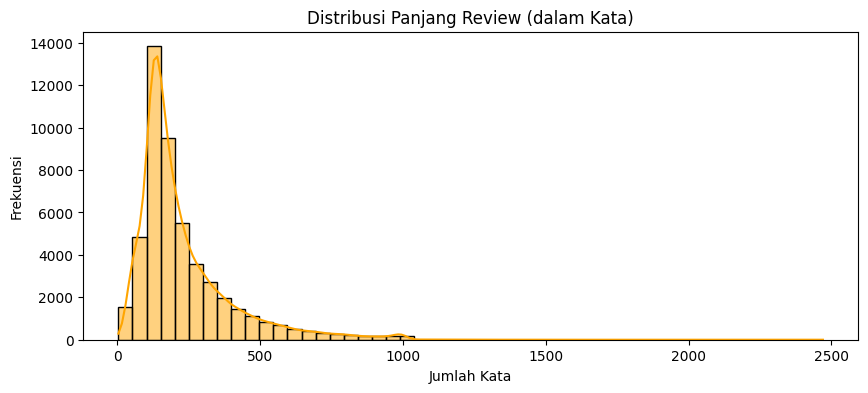

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribusi panjang karakter
plt.figure(figsize=(10, 4))
sns.histplot(df['char_count'], bins=50, kde=True)
plt.title('Distribusi Panjang Review (dalam Karakter)')
plt.xlabel('Jumlah Karakter')
plt.ylabel('Frekuensi')
plt.show()

# Distribusi panjang kata
plt.figure(figsize=(10, 4))
sns.histplot(df['word_count'], bins=50, kde=True, color='orange')
plt.title('Distribusi Panjang Review (dalam Kata)')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()

In [ ]:
df.isnull().sum()

,0
review,0
sentiment,0
char_count,0
word_count,0


In [ ]:
df.duplicated().sum()

np.int64(418)

#Pre-Processing

##Drop Duplicates


In [ ]:
#drop duplikasi data
df.drop_duplicates(inplace=True)

## Cleaning Text

In [ ]:
def clean_text(text):
    # Ubah ke huruf kecil
    text = text.lower()

    # Hapus URL
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Hapus tag HTML
    text = re.sub(r'<.*?>', '', text)

    # Hapus emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F700-\U0001F77F"  # alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess Symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251"  # Enclosed characters
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
df['clean_review'] = df['review'].apply(clean_text)
df[['review', 'clean_review']].head()

,review,clean_review
0,One of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,a wonderful little production. the filming tec...
2,I thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...","petter mattei's ""love in the time of money"" is..."


In [ ]:
df = df[['review', 'sentiment', 'clean_review']]
df

,review,sentiment,clean_review
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production. the filming tec...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"petter mattei's ""love in the time of money"" is..."
...,...,...,...
49995,I thought this movie did a down right good job...,positive,i thought this movie did a down right good job...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,"bad plot, bad dialogue, bad acting, idiotic di..."
49997,I am a Catholic taught in parochial elementary...,negative,i am a catholic taught in parochial elementary...
49998,I'm going to have to disagree with the previou...,negative,i'm going to have to disagree with the previou...


##Label Encoding

In [ ]:
# Ubah label sentimen ke angka: negative = 0, positive = 1
df['label'] = df['sentiment'].map({'negative': 0, 'positive': 1})
df

,review,sentiment,clean_review,label
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production. the filming tec...,1
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"petter mattei's ""love in the time of money"" is...",1
...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,i thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,"bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,negative,i am a catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,negative,i'm going to have to disagree with the previou...,0


##Data Splitting

In [ ]:
# Shuffle data
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)

# Split data: 80% train, 10% val, 10% test
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['sentiment'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['sentiment'])

# Siapkan teks dan label
X_train_texts = train_df['clean_review'].values
X_val_texts   = val_df['clean_review'].values
X_test_texts  = test_df['clean_review'].values

y_train = train_df['label'].values
y_val   = val_df['label'].values
y_test  = test_df['label'].values

# Melihat distribusi label pada data latih, validasi, dan uji
import pandas as pd

print("Distribusi Label:")
print("\nTrain Set:")
print(pd.Series(y_train).value_counts())

print("\nValidation Set:")
print(pd.Series(y_val).value_counts())

print("\nTest Set:")
print(pd.Series(y_test).value_counts())


Distribusi Label:

Train Set:
1    19907
0    19758
Name: count, dtype: int64

Validation Set:
1    2488
0    2470
Name: count, dtype: int64

Test Set:
1    2489
0    2470
Name: count, dtype: int64


##Tokenization

In [ ]:
# Tokenisasi
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_texts)

# Konversi teks ke sequence
X_train_seq = tokenizer.texts_to_sequences(X_train_texts)
X_val_seq   = tokenizer.texts_to_sequences(X_val_texts)
X_test_seq  = tokenizer.texts_to_sequences(X_test_texts)

# Padding sequence (agar panjang sama)
maxlen = 260  # atau sesuaikan dengan distribusi panjang review
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
X_val_pad   = pad_sequences(X_val_seq, maxlen=maxlen, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')

##Set Seed

In [ ]:
def set_seed(seed_value):
    """
    Fungsi untuk mengatur random seed agar hasil reproducible.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # untuk multi-GPU
        # Pengaturan ini penting untuk hasil yang konsisten di GPU
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 42 # Angka bisa berapa saja, yang penting konsisten
set_seed(SEED)

# Arsitektur Model

##RNN

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=32, output_dim=1,
                 n_layers=1, dropout=0.2, bidirectional=True):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout if n_layers > 1 else 0.0,
            batch_first=True
        )
        self.dropout = nn.Dropout(dropout)
        self.bidirectional = bidirectional
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)                          # [B, T] → [B, T, E]
        rnn_out, hidden = self.rnn(embedded)                  # hidden: [L, B, H]

        if self.bidirectional:
            last_hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)  # [B, H*2]
        else:
            last_hidden = hidden[-1]                          # [B, H]

        out = self.dropout(last_hidden)
        out = self.fc(out)                                    # [B, 1]
        return out.squeeze(1)                                 # [B]

##LSTM

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=32, output_dim=1,
                 n_layers=1, dropout=0.2, bidirectional=True):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout if n_layers > 1 else 0.0,
            batch_first=True
        )
        self.dropout = nn.Dropout(dropout)
        self.bidirectional = bidirectional
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)                          # [B, T, E]
        lstm_out, (hidden, cell) = self.lstm(embedded)

        if self.bidirectional:
            last_hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)  # [B, H*2]
        else:
            last_hidden = hidden[-1]                          # [B, H]

        out = self.dropout(last_hidden)
        out = self.fc(out)                                    # [B, 1]
        return out.squeeze(1)                                 # [B]

#Konfigurasi Model

In [ ]:
# Contoh tokenisasi sederhana
tokenized_texts = [text.split() for text in df['clean_review']]
word_counts = Counter(word for tokens in tokenized_texts for word in tokens)
most_common = word_counts.most_common(5000)
vocab = {word: idx+2 for idx, (word, _) in enumerate(most_common)}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

vocab_size = len(vocab)
print(vocab_size)

# Tentukan device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

######Inisialisasi model RNN
rnn_model = RNNModel(
    vocab_size=vocab_size,    # Ubah ini sesuai kamusmu
    embedding_dim=64,
    hidden_dim=32,
    output_dim=1,
    n_layers=1,
    dropout=0.2,
    bidirectional=True
)

# Kirim ke device
rnn_model = rnn_model.to(device)

# Loss function dan optimizer
criterion_rnn = nn.BCEWithLogitsLoss()
optimizer_rnn = torch.optim.Adam(rnn_model.parameters(), lr=1e-3)

######Inisialisasi model LSTM
lstm_model = LSTMModel(
    vocab_size=vocab_size,
    embedding_dim=64,
    hidden_dim=32,
    output_dim=1,
    n_layers=1,
    dropout=0.2,
    bidirectional=True
)

# Kirim ke device
lstm_model = lstm_model.to(device)

# Loss function dan optimizer
criterion_lstm = nn.BCEWithLogitsLoss()
optimizer_lstm = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)

5002


#Data Loader

In [ ]:
# Konversi data ke torch.Tensor
X_train_tensor = torch.LongTensor(X_train_pad)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.LongTensor(X_val_pad)
y_val_tensor = torch.FloatTensor(y_val)
X_test_tensor = torch.LongTensor(X_test_pad)
y_test_tensor = torch.FloatTensor(y_test)

# Buat TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Buat DataLoader
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
# Cek device (GPU atau CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


#Training and Utility Functions

##Fungsi Train Model

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, n_epochs, clip, patience):
    """
    Fungsi untuk melatih model, dengan Early Stopping dan perekaman gradien per layer per epoch.
    (Versi Lengkap dan Terkoreksi)
    """
    model.to(device)
    # Inisialisasi history untuk loss, akurasi, dan gradien
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    gradient_history = {'embedding': [], 'rnn_lstm': [], 'fc': []}

    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(n_epochs):
        # Inisialisasi list sementara untuk gradien di setiap epoch
        epoch_grads = {'embedding': [], 'rnn_lstm': [], 'fc': []}

        # ====================================================================
        # BAGIAN YANG MEMPERBAIKI ERROR ADA DI BAWAH INI
        # Variabel ini harus direset ke 0 di setiap awal epoch.
        model.train()
        total_loss, total_correct = 0, 0
        # ====================================================================

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Investigasi gradien per layer
            for name, p in model.named_parameters():
                if p.grad is not None:
                    grad_norm = p.grad.data.norm(2).item()
                    if 'embedding' in name:
                        epoch_grads['embedding'].append(grad_norm)
                    elif 'rnn' in name or 'lstm' in name:
                        epoch_grads['rnn_lstm'].append(grad_norm)
                    elif 'fc' in name:
                        epoch_grads['fc'].append(grad_norm)

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

            # Akumulasi loss dan akurasi untuk data training
            total_loss += loss.item() * inputs.size(0)
            preds = torch.round(torch.sigmoid(outputs))
            total_correct += (preds == labels).sum().item()

        # Hitung rata-rata loss dan akurasi training setelah semua batch selesai
        avg_train_loss = total_loss / len(train_loader.dataset)
        avg_train_acc = total_correct / len(train_loader.dataset)

        # Setelah semua batch dalam satu epoch selesai, hitung rata-rata gradien per layer
        for layer_name, grads in epoch_grads.items():
            if grads:
                gradient_history[layer_name].append(np.mean(grads))
            else:
                gradient_history[layer_name].append(0)

        # Evaluasi pada data validasi
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                preds = torch.round(torch.sigmoid(outputs))
                val_correct += (preds == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader.dataset)
        avg_val_acc = val_correct / len(val_loader.dataset)

        # Simpan semua history
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(avg_train_acc)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(avg_val_acc)

        print(f"Epoch {epoch+1}/{n_epochs} | "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}")

        # Logika Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), f'best_model_{model.__class__.__name__}.pth')
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    # Muat bobot model terbaik sebelum mengembalikan
    print(f"Loading best model from epoch with validation loss: {best_val_loss:.4f}")
    model.load_state_dict(torch.load(f'best_model_{model.__class__.__name__}.pth'))

    return history, gradient_history

##Fungsi Plot Loss & Accuracy

In [ ]:
def plot_history(history_rnn, history_lstm, title):
    """
    Fungsi untuk plot loss dan akurasi dalam 4 gambar terpisah (grid 2x2).
    """
    # Membuat figure dengan grid 2x2. `axs` akan menjadi array 2x2 dari sumbu plot.
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Menambahkan judul utama untuk keseluruhan figure
    fig.suptitle(title, fontsize=16)

    # --- Plot untuk RNN ---

    # 1. Plot RNN Loss (kiri-atas, posisi [0, 0])
    axs[0, 0].plot(history_rnn['train_loss'], label='Train Loss', color='blue', linestyle='--')
    axs[0, 0].plot(history_rnn['val_loss'], label='Validation Loss', color='red')
    axs[0, 0].set_title('RNN Performance - Loss')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()
    axs[0, 0].grid(True, linestyle=':', alpha=0.7)

    # 2. Plot RNN Accuracy (kanan-atas, posisi [0, 1])
    axs[0, 1].plot(history_rnn['train_acc'], label='Train Accuracy', color='blue', linestyle='--')
    axs[0, 1].plot(history_rnn['val_acc'], label='Validation Accuracy', color='red')
    axs[0, 1].set_title('RNN Performance - Accuracy')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].legend()
    axs[0, 1].grid(True, linestyle=':', alpha=0.7)

    # --- Plot untuk LSTM ---

    # 3. Plot LSTM Loss (kiri-bawah, posisi [1, 0])
    axs[1, 0].plot(history_lstm['train_loss'], label='Train Loss', color='orange', linestyle='--')
    axs[1, 0].plot(history_lstm['val_loss'], label='Validation Loss', color='green')
    axs[1, 0].set_title('LSTM Performance - Loss')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].legend()
    axs[1, 0].grid(True, linestyle=':', alpha=0.7)

    # 4. Plot LSTM Accuracy (kanan-bawah, posisi [1, 1])
    axs[1, 1].plot(history_lstm['train_acc'], label='Train Accuracy', color='orange', linestyle='--')
    axs[1, 1].plot(history_lstm['val_acc'], label='Validation Accuracy', color='green')
    axs[1, 1].set_title('LSTM Performance - Accuracy')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Accuracy')
    axs[1, 1].legend()
    axs[1, 1].grid(True, linestyle=':', alpha=0.7)

    # Secara otomatis mengatur layout agar rapi dan tidak tumpang tindih
    plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # rect disesuaikan untuk memberi ruang bagi judul utama
    plt.show()

##Fungsi Plot Gradient

In [ ]:
def plot_gradients_per_layer(grad_history, model_name):
    """Fungsi untuk plot rata-rata norma gradien per layer per epoch untuk satu model."""
    fig, ax = plt.subplots(figsize=(8, 6))

    for layer_name, grads in grad_history.items():
        # Sesuaikan label agar lebih spesifik per model
        label = f'{model_name} {layer_name}' if layer_name != 'fc' else f'{model_name} fc layer'
        ax.plot(grads, label=label)

    ax.set_title(f'{model_name}: Average Gradient Norm per Layer')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Average Gradient Norm')
    ax.set_yscale('log')  # Skala log untuk melihat vanishing gradient
    ax.legend()
    ax.grid(True, which="both", ls="--", alpha=0.5)
    plt.show()

##Fungsi Evaluasi Model

In [ ]:
def evaluate_and_analyze(model, test_loader, test_texts, model_name):
    """
    Fungsi untuk evaluasi akhir dan analisis kesalahan (long-term dependencies).
    """
    model.to(device)
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.round(torch.sigmoid(outputs))
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"\n--- [ANALISIS MODEL: {model_name}] ---")
    # 1. Classification Report & Confusion Matrix
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Negative', 'Positive']))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    # 2. Analisis Long-Term Dependencies via Error Analysis
    test_df = pd.DataFrame({'text': test_texts, 'true': all_labels, 'pred': all_preds})
    test_df['text_len'] = test_df['text'].apply(lambda x: len(x.split()))
    misclassified = test_df[test_df['true'] != test_df['pred']]
    correctly_classified = test_df[test_df['true'] == test_df['pred']]

    print("\nAnalisis Panjang Teks (Long-Term Dependencies):")
    print(f"Rata-rata panjang teks yang diprediksi BENAR: {correctly_classified['text_len'].mean():.2f} kata")
    print(f"Rata-rata panjang teks yang diprediksi SALAH: {misclassified['text_len'].mean():.2f} kata")

    # Tampilkan beberapa contoh ulasan panjang yang salah klasifikasi
    pd.set_option('display.max_colwidth', 300)
    long_misclassified = misclassified[misclassified['text_len'] > 300].head(3)
    if not long_misclassified.empty:
        print("\nContoh Ulasan PANJANG yang Salah Klasifikasi:")
        print(long_misclassified[['text', 'true', 'pred', 'text_len']])
    else:
        print("\nTidak ditemukan ulasan panjang (>300 kata) yang salah klasifikasi.")

#Parameter Training

In [ ]:
# Hyperparameters (telah disesuaikan)
VOCAB_SIZE = len(tokenizer.word_index) + 1
EMBEDDING_DIM = 128
HIDDEN_DIM = 64
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
LEARNING_RATE = 0.001
N_EPOCHS = 50      # Epoch diubah menjadi 50
CLIP = 1.0
PATIENCE = 10      # Menambahkan patience untuk early stopping

# Inisialisasi model, optimizer, dan criterion
set_seed(37)

##Train RNN

In [ ]:
# --- Training RNN ---
print("--- Mulai Training Model RNN ---")
rnn_model = RNNModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT, BIDIRECTIONAL)
optimizer_rnn = optim.Adam(rnn_model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()
# Memanggil fungsi training dengan parameter patience
rnn_history, rnn_gradients = train_model(rnn_model, train_loader, val_loader, optimizer_rnn, criterion, N_EPOCHS, CLIP, PATIENCE)

--- Mulai Training Model RNN ---
Epoch 1/50 | Train Loss: 0.6898, Train Acc: 0.5454 | Val Loss: 0.6585, Val Acc: 0.6140
Epoch 2/50 | Train Loss: 0.6137, Train Acc: 0.6766 | Val Loss: 0.5536, Val Acc: 0.7342
Epoch 3/50 | Train Loss: 0.5569, Train Acc: 0.7264 | Val Loss: 0.5452, Val Acc: 0.7317
Epoch 4/50 | Train Loss: 0.5172, Train Acc: 0.7611 | Val Loss: 0.5108, Val Acc: 0.7707
Epoch 5/50 | Train Loss: 0.4796, Train Acc: 0.7856 | Val Loss: 0.4883, Val Acc: 0.7751
Epoch 6/50 | Train Loss: 0.4347, Train Acc: 0.8143 | Val Loss: 0.4826, Val Acc: 0.7852
Epoch 7/50 | Train Loss: 0.4062, Train Acc: 0.8280 | Val Loss: 0.4884, Val Acc: 0.7777
Epoch 8/50 | Train Loss: 0.3937, Train Acc: 0.8388 | Val Loss: 0.5616, Val Acc: 0.7626
Epoch 9/50 | Train Loss: 0.3691, Train Acc: 0.8527 | Val Loss: 0.5060, Val Acc: 0.7785
Epoch 10/50 | Train Loss: 0.3502, Train Acc: 0.8628 | Val Loss: 0.5712, Val Acc: 0.7463
Epoch 11/50 | Train Loss: 0.3239, Train Acc: 0.8765 | Val Loss: 0.5260, Val Acc: 0.7715
Epoch 12

##Train LSTM

In [ ]:
# --- Training LSTM ---
print("\n--- Mulai Training Model LSTM ---")
lstm_model = LSTMModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT, BIDIRECTIONAL)
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()
# Memanggil fungsi training dengan parameter patience
lstm_history, lstm_gradients = train_model(lstm_model, train_loader, val_loader, optimizer_lstm, criterion, N_EPOCHS, CLIP, PATIENCE)


--- Mulai Training Model LSTM ---
Epoch 1/50 | Train Loss: 0.6207, Train Acc: 0.6477 | Val Loss: 0.5322, Val Acc: 0.7394
Epoch 2/50 | Train Loss: 0.4623, Train Acc: 0.7970 | Val Loss: 0.4253, Val Acc: 0.8296
Epoch 3/50 | Train Loss: 0.3613, Train Acc: 0.8518 | Val Loss: 0.3515, Val Acc: 0.8503
Epoch 4/50 | Train Loss: 0.2982, Train Acc: 0.8816 | Val Loss: 0.3212, Val Acc: 0.8628
Epoch 5/50 | Train Loss: 0.2501, Train Acc: 0.9027 | Val Loss: 0.2968, Val Acc: 0.8717
Epoch 6/50 | Train Loss: 0.2072, Train Acc: 0.9219 | Val Loss: 0.3154, Val Acc: 0.8828
Epoch 7/50 | Train Loss: 0.1756, Train Acc: 0.9369 | Val Loss: 0.3069, Val Acc: 0.8838
Epoch 8/50 | Train Loss: 0.1498, Train Acc: 0.9462 | Val Loss: 0.3441, Val Acc: 0.8828
Epoch 9/50 | Train Loss: 0.1217, Train Acc: 0.9603 | Val Loss: 0.3307, Val Acc: 0.8887
Epoch 10/50 | Train Loss: 0.1002, Train Acc: 0.9680 | Val Loss: 0.3567, Val Acc: 0.8850
Epoch 11/50 | Train Loss: 0.0813, Train Acc: 0.9750 | Val Loss: 0.3917, Val Acc: 0.8840
Epoch 

#Evaluasi

##Loss & Accuracy

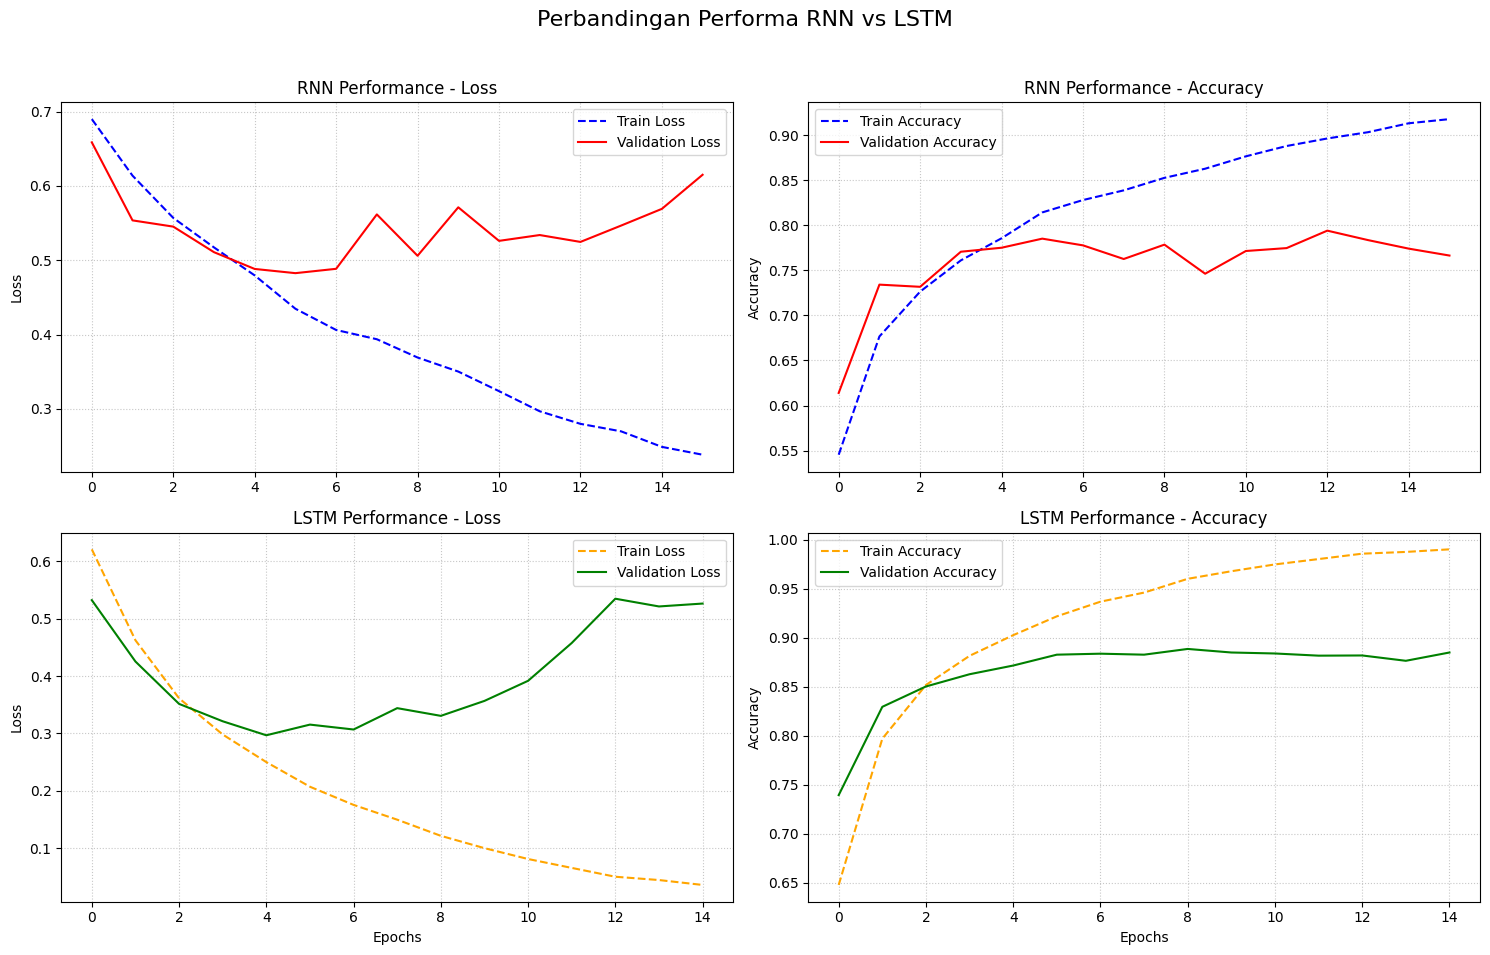

In [ ]:
# Plot Perbandingan Kurva Training
plot_history(rnn_history, lstm_history, "Perbandingan Performa RNN vs LSTM")

**RNN**:
* Train Loss: Terus menurun selama 15 epoch, menunjukkan model belajar dari data train.
* Validation Loss: Cenderung stagnan dan bahkan naik setelah epoch ke-6, mengindikasikan potensi overfitting.
* Train Accuracy: Terus meningkat secara signifikan.
* Validation Accuracy: Tidak meningkat konsisten, berhenti sekitar 78–79%.

**LSTM**:
* Train Loss: Turun tajam dan stabil hingga sangat rendah.
* Validation Loss: Turun sampai epoch ke-5, lalu sedikit naik tapi tetap lebih stabil dari RNN.
* Train Accuracy: Meningkat hingga hampir 99%.
* Validation Accuracy: Stabil hampir menyentuh 90%, menunjukkan generalisasi lebih baik daripada RNN.
![picture](https://drive.google.com/uc?id=1U7rNimxkiplhhs3SaFn8z7A8O87pEHvS)


##Gradient

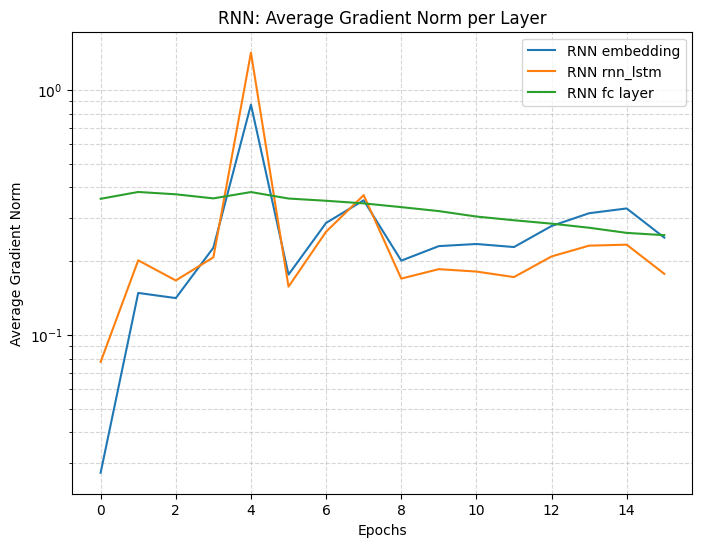

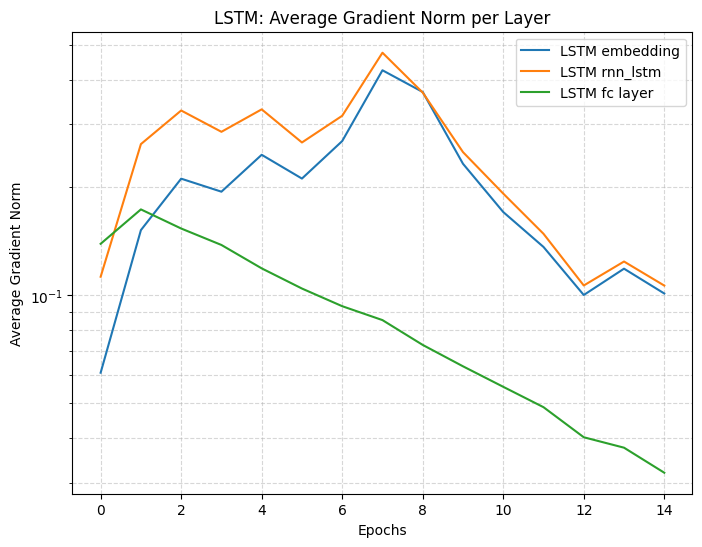

In [ ]:
# Panggil fungsi untuk masing-masing model
plot_gradients_per_layer(rnn_gradients, "RNN")
plot_gradients_per_layer(lstm_gradients, "LSTM")

**RNN**:
* Layer Embedding & RNN:
Fluktuatif, terutama spike besar di epoch ke-4, kemungkinan terjadi exploding gradient.
* Layer FC (Linear):
Stabil tapi cenderung stagnan.

**LSTM**:
* Semua Layer:
Menunjukkan penurunan konsisten pada norm gradien.
* Lebih stabil dibandingkan RNN, tidak ada lonjakan tajam, menandakan LSTM lebih stabil dalam proses belajar.

![picture](https://drive.google.com/uc?id=1JZAeAlvbjUMnCx30OcVZibsNpaTOtgSL)

##Confusion Matrix


--- [ANALISIS MODEL: RNN] ---
Classification Report:
              precision    recall  f1-score   support

    Negative       0.77      0.81      0.79      2470
    Positive       0.80      0.76      0.78      2489

    accuracy                           0.78      4959
   macro avg       0.78      0.78      0.78      4959
weighted avg       0.78      0.78      0.78      4959



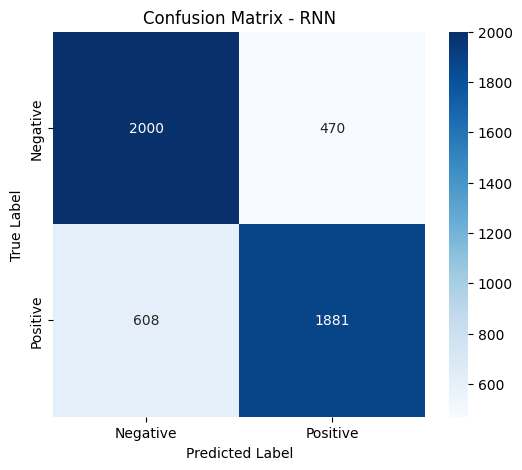


Analisis Panjang Teks (Long-Term Dependencies):
Rata-rata panjang teks yang diprediksi BENAR: 223.81 kata
Rata-rata panjang teks yang diprediksi SALAH: 247.15 kata

Contoh Ulasan PANJANG yang Salah Klasifikasi:
                                                                                                                                                                                                                                                                                                           text  \
6   when you put this dvd into your player and hit "play," you will experience a brief moment of silence and see a black screen as the laser is guided to the correct starting point in the center of the disc. cherish this moment. make sure you have some tylenol or something (preferably pm's so you ca...   
32  i'm not a big fan of most anime, but gundam wing is truly something else. gundam wing lacks all of that stereotypical melodrama that you might think of when you think of 

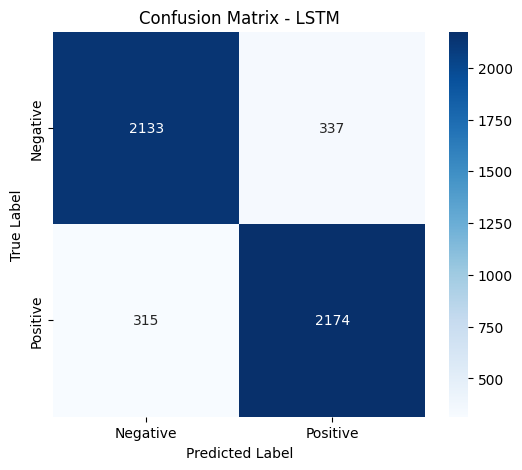


Analisis Panjang Teks (Long-Term Dependencies):
Rata-rata panjang teks yang diprediksi BENAR: 224.25 kata
Rata-rata panjang teks yang diprediksi SALAH: 259.48 kata

Contoh Ulasan PANJANG yang Salah Klasifikasi:
                                                                                                                                                                                                                                                                                                           text  \
32  i'm not a big fan of most anime, but gundam wing is truly something else. gundam wing lacks all of that stereotypical melodrama that you might think of when you think of anime, since the number of jokes made over the 17 hours would only be in the double digits, gundam wing gets right down to bus...   
37  "descent." yeah. boy... i haven't seen anything this powerful and scintillating since bruno dumont's, "twentynine palms" (2003). (by the way this film is not to be confus

In [ ]:
# 3. Evaluasi dan Analisis pada Test Set
evaluate_and_analyze(rnn_model, test_loader, X_test_texts, "RNN")
evaluate_and_analyze(lstm_model, test_loader, X_test_texts, "LSTM")

**RNN**:
* Untuk kelas Negative, precision-nya 77% dan recall-nya 81%. Ini berarti model cukup baik dalam mengidentifikasi review negatif.
Sedangkan untuk kelas Positive, precision-nya 80% dan recall-nya 76%. Artinya, RNN agak kesulitan mengenali review positif, karena ada cukup banyak positif yang salah diklasifikasikan sebagai negatif.
* Nilai F1-score, yaitu gabungan antara precision dan recall, cukup seimbang untuk kedua kelas, tapi secara umum masih menunjukkan bahwa model ini belum optimal, terutama dalam konteks generalisasi di data uji.

**LSTM**:
* Akurasi model LSTM mencapai 88%, naik 10% dari RNN. Baik precision maupun recall untuk kedua kelas, negatif maupun positif, masing-masing berada di angka 87–88%, dengan F1-score yang juga tinggi dan seimbang.
* Ini menunjukkan bahwa LSTM tidak hanya mampu mengenali sentimen dengan lebih baik, tapi juga memiliki ketepatan dan sensitivitas yang jauh lebih tinggi, baik saat mendeteksi ulasan negatif maupun positif.
Dari sini sudah terlihat bahwa LSTM adalah model yang lebih unggul, terutama dalam hal klasifikasi yang seimbang dan akurat.


##Perbandingan Prediksi RNN vs LSTM yang Berbeda

In [ ]:
def get_all_preds(model, data_loader, device):
    """Fungsi pembantu untuk mendapatkan semua prediksi dari sebuah model."""
    model.eval()
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.round(torch.sigmoid(outputs))
            all_predictions.extend(preds.cpu().numpy())
    return all_predictions

# Dapatkan daftar prediksi dari kedua model pada data uji
rnn_predictions = get_all_preds(rnn_model, test_loader, device)
lstm_predictions = get_all_preds(lstm_model, test_loader, device)

# Buat DataFrame perbandingan dari semua hasil
comparison_df = pd.DataFrame({
    'clean_review': X_test_texts,
    'label_sebenarnya': y_test,
    'prediksi_rnn': rnn_predictions,
    'prediksi_lstm': lstm_predictions
})

label_map = {0: 'Negative', 1: 'Positive'}
comparison_df['label_sebenarnya'] = comparison_df['label_sebenarnya'].map(label_map)
comparison_df['prediksi_rnn'] = comparison_df['prediksi_rnn'].astype(int).map(label_map)
comparison_df['prediksi_lstm'] = comparison_df['prediksi_lstm'].astype(int).map(label_map)

In [ ]:
# Tambahkan kolom baru untuk menghitung jumlah kata di setiap ulasan
comparison_df['jumlah_kata'] = comparison_df['clean_review'].apply(lambda x: len(x.split()))

# Definisikan kedua kondisi filter
kondisi_1 = comparison_df['prediksi_rnn'] != comparison_df['prediksi_lstm']
kondisi_2 = comparison_df['jumlah_kata'] > 300

# Gabungkan kedua kondisi menggunakan operator '&' (AND) dan tampilkan hasilnya
print("--- Ulasan Panjang (>300 Kata) di Mana Prediksi RNN dan LSTM Berbeda ---")
ulasan_spesifik = comparison_df[kondisi_1 & kondisi_2]

display(ulasan_spesifik.head(3))

--- Ulasan Panjang (>300 Kata) di Mana Prediksi RNN dan LSTM Berbeda ---


,clean_review,label_sebenarnya,prediksi_rnn,prediksi_lstm,jumlah_kata
6,"when you put this dvd into your player and hit ""play,"" you will experience a brief moment of silence and see a black screen as the laser is guided to the correct starting point in the center of the disc. cherish this moment. make sure you have some tylenol or something (preferably pm's so you can fall asleep), because you're going to have a massive headache once this movie starts.starring a bunch of big-breasted girls and with an opening that actually made me chuckle a bit, i thought i'd be in for a good time. sure, the opening sequence was a wee bit awkward and most of the jokes fell flat and it seemed like this was going to be a scream ripoff (by the way, my sole chuckle was from julie strain's final comment in this scene). but then i knew there was trouble... the opening sequence had a terrible rock song. during this terrible rock song, i looked over the dvd chapter titles and saw things that said ""topless in the backyard!"" and ""better than sex!"". i knew what the selling point of this movie was going to be.and that's the sad truth: the only good thing about this movie is the attractive cast. other than that, it's a sadly routine slasher film that throws in an ""innovative"" concept about murder clubs, which ends up being fake anyway. so, the whole movie then points in another direction to try to be confusing and this huge mystery, but it all just adds up to not being interesting at all and leaves you feeling like you don't care for any of the characters. i mean, when the main character of the movie is revealed to have murdered an innocent woman, can you really feel any sympathy towards her when she's in fear for her life? the scream influence is prevalent throughout, with a ghost face killer and some really terrible jokes. we're also treated to scenes of the main character talking to her mom and dad (lloyd kaufman! the only other cool part of the movie!) about an abortion or something. uh. yeah... this isn't a ""so-bad-it's-good"" movie, it's just bad.someone compared this to a troma film, but... you know, most any film that comes from full moon (or its offshoot, as this film proves) is horrible. not horrible in a troma sense -- i've seen many troma films, and i can honestly say they all offer something, anything that you can walk away with and tell your friends about later. however, this film has pretty much nothing at all enjoyable about it. beware.",Negative,Positive,Negative,434
126,"...as valuable as king tut's tomb! (ok, maybe not that valuable, but worth hunting down if you can). i notice no one has commented on this movie for some years, and i hope a fresh post will spark some new comments. this is a film that i remembered only snippets of from childhood, and only saw recently when i tired of waiting for fox to honour its own past, and hunted down the korean dvd (in english, but with unremovable korean subtitles). i won't go through another long plot description - suffice to say that seeing it for the first time in its proper widescreen format left me agape at the vistas and the scope of the film. the matte paintings still hold up, and the palace sets are truly breathtaking. but it is the smaller scale details that lend this film its depth and richness, offering a glimpse into the lifestyles of egypt's poor as well as its elite. the bazaars, hovels, docks, embalming houses, and taverns are as fascinating as pharaoh's throne room. while errors abound on the large scale (most notably the dynastic succession), the details are more meticulously researched than the vast majority of hollywood's films. visually, it's not without its flaws - the interiors are often too overly lit and colourful to blend seamlessly with the exteriors. nevertheless, this is a movie that should be credited for being as audacious in the small as it is in the large. tedious? in parts, absolutely. overacted? underacted? yes, both - though 'understated' might be a more a

* Dari evaluasi ini, ditemukan bahwa LSTM lebih sering memberikan prediksi yang benar dibandingkan RNN pada review panjang. Ini menegaskan bahwa kelebihan LSTM dalam mempertahankan long-term dependencies berdampak nyata terhadap hasil klasifikasi.
* Ulasan panjang membutuhkan pemahaman konteks yang menyeluruh, dan LSTM terbukti lebih mampu menangkap informasi dari awal hingga akhir ulasan secara stabil.


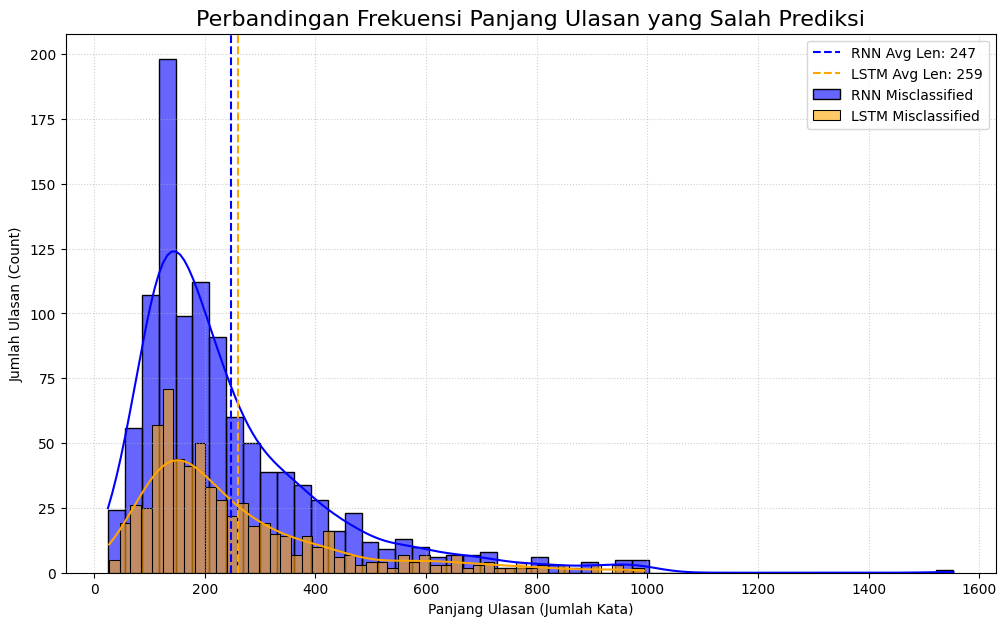

In [ ]:
def plot_misclassified_length_distribution(misclassified_rnn, misclassified_lstm):
    """
    Membuat plot distribusi (histogram) dari panjang teks ulasan
    yang salah diklasifikasikan oleh RNN dan LSTM dengan sumbu Y sebagai count.
    """
    plt.figure(figsize=(12, 7))

    # Mengubah sns.kdeplot menjadi sns.histplot untuk membuat histogram
    # alpha digunakan untuk membuat bar menjadi transparan agar tidak saling menutupi
    sns.histplot(data=misclassified_rnn, x='text_len', label='RNN Misclassified',
                 color='blue', alpha=0.6, bins=50, kde=True)

    sns.histplot(data=misclassified_lstm, x='text_len', label='LSTM Misclassified',
                 color='orange', alpha=0.6, bins=50, kde=True)

    # Garis vertikal untuk rata-rata tetap dipertahankan
    plt.axvline(misclassified_rnn['text_len'].mean(), color='blue', linestyle='--',
                label=f"RNN Avg Len: {misclassified_rnn['text_len'].mean():.0f}")
    plt.axvline(misclassified_lstm['text_len'].mean(), color='orange', linestyle='--',
                label=f"LSTM Avg Len: {misclassified_lstm['text_len'].mean():.0f}")

    plt.title('Perbandingan Frekuensi Panjang Ulasan yang Salah Prediksi', fontsize=16)
    plt.xlabel('Panjang Ulasan (Jumlah Kata)')

    # Mengubah label sumbu Y dari "Kepadatan (Density)" menjadi "Jumlah (Count)"
    plt.ylabel('Jumlah Ulasan (Count)')

    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

# Filter 'comparison_df' untuk mendapatkan ulasan yang salah prediksi oleh masing-masing model
misclassified_rnn = comparison_df[comparison_df['label_sebenarnya'] != comparison_df['prediksi_rnn']].copy()
misclassified_lstm = comparison_df[comparison_df['label_sebenarnya'] != comparison_df['prediksi_lstm']].copy()

# Hitung panjang teks untuk setiap dataframe kesalahan
misclassified_rnn['text_len'] = misclassified_rnn['clean_review'].apply(lambda x: len(x.split()))
misclassified_lstm['text_len'] = misclassified_lstm['clean_review'].apply(lambda x: len(x.split()))

# Panggil fungsi plot dengan data yang sudah disiapkan
plot_misclassified_length_distribution(misclassified_rnn, misclassified_lstm)

**RNN Lebih Rentan Gagal di Ulasan Panjang:**
* Ulasan panjang (<400 kata) cenderung lebih sering salah diklasifikasi oleh RNN dibandingkan LSTM.
* Hal ini bisa dikaitkan dengan vanishing gradient dan ketidakmampuan RNN menangkap konteks panjang.

**LSTM Lebih Stabil di Rentang Panjang:**
* LSTM menunjukkan distribusi kesalahan yang lebih stabil dan tidak terlalu ekstrem di ulasan panjang.
* Ini menunjukkan kemampuannya mengingat konteks jangka panjang.
Rata-Rata Panjang Teks Salah Klasifikasi:
* RNN Avg Len: 247 kata
* LSTM Avg Len: 259 kata

##Distribusi Panjang Ulasan (LSTM Benar, RNN Salah)

Ditemukan 685 ulasan di mana LSTM Benar dan RNN Salah.
Berikut adalah beberapa contohnya:


,clean_review,label_sebenarnya,prediksi_rnn,prediksi_lstm,jumlah_kata
1,"i channel surfed past this many times, mainly because the synopsis sounded so cheesy, so ""love american style"". however, it turned out to be quite good, very well done. the two stand-out features are the dialog and acting. great cast. the premise is actually well executed and there aren't too many weak moments. i guess what i was most amazed by was how often you thought the wheels are going to come off the cart, and instead, the cart just banks the turns, so to speak, and the movie keeps flying. there are some nice little sub-plots, particularly the relationship that develops between the character played by former conan sidekick andy richter. also, want to mention that the music accompanying it was good.",Positive,Negative,Positive,123
6,"when you put this dvd into your player and hit ""play,"" you will experience a brief moment of silence and see a black screen as the laser is guided to the correct starting point in the center of the disc. cherish this moment. make sure you have some tylenol or something (preferably pm's so you can fall asleep), because you're going to have a massive headache once this movie starts.starring a bunch of big-breasted girls and with an opening that actually made me chuckle a bit, i thought i'd be in for a good time. sure, the opening sequence was a wee bit awkward and most of the jokes fell flat and it seemed like this was going to be a scream ripoff (by the way, my sole chuckle was from julie strain's final comment in this scene). but then i knew there was trouble... the opening sequence had a terrible rock song. during this terrible rock song, i looked over the dvd chapter titles and saw things that said ""topless in the backyard!"" and ""better than sex!"". i knew what the selling point of this movie was going to be.and that's the sad truth: the only good thing about this movie is the attractive cast. other than that, it's a sadly routine slasher film that throws in an ""innovative"" concept about murder clubs, which ends up being fake anyway. so, the whole movie then points in another direction to try to be confusing and this huge mystery, but it all just adds up to not being interesting at all and leaves you feeling like you don't care for any of the characters. i mean, when the main character of the movie is revealed to have murdered an innocent woman, can you really feel any sympathy towards her when she's in fear for her life? the scream influence is prevalent throughout, with a ghost face killer and some really terrible jokes. we're also treated to scenes of the main character talking to her mom and dad (lloyd kaufman! the only other cool part of the movie!) about an abortion or something. uh. yeah... this isn't a ""so-bad-it's-good"" movie, it's just bad.someone compared this to a troma film, but... you know, most any film that comes from full moon (or its offshoot, as this film proves) is horrible. not horrible in a troma sense -- i've seen many troma films, and i can honestly say they all offer something, anything that you can walk away with and tell your friends about later. however, this film has pretty much nothing at all enjoyable about it. beware.",Negative,Positive,Negative,434
30,"gung ho tries to express many ideas and entertain us with a wiseguy comedy at the same time. the result is uneven, but generally entertaining. keaton balances all three aspects of his lead character quite well. wantabedde is even better. one warning: george wendt is very poor in his supporting role. otherwise, this is quite enjoyable time capsule.",Positive,Negative,Positive,58
35,"i usually like hongkong - martial arts - fantasy movies but i hated this one. once upon a time in china, shogun assassin, a chinese ghost story and even big trouble in little china are my favorites but this film sucked! too much fancy tricks and stupid story.4/10",Negative,Positive,Negative,48
36,"i caught this movie right in my eye when i was passin


--- Plot Distribusi Panjang Kata (Kasus LSTM Unggul) ---


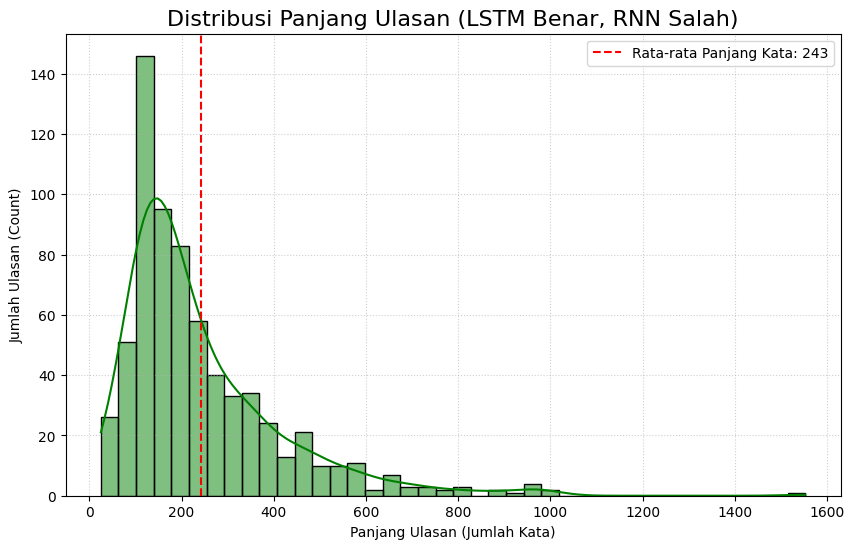

In [ ]:
if 'jumlah_kata' not in comparison_df.columns:
    comparison_df['jumlah_kata'] = comparison_df['clean_review'].apply(lambda x: len(x.split()))

# Definisikan kondisi filter
kondisi_lstm_benar = comparison_df['label_sebenarnya'] == comparison_df['prediksi_lstm']
kondisi_rnn_salah = comparison_df['label_sebenarnya'] != comparison_df['prediksi_rnn']

# Gabungkan kondisi untuk mendapatkan kasus di mana LSTM lebih unggul
lstm_superior_df = comparison_df[kondisi_lstm_benar & kondisi_rnn_salah]

# Tampilkan informasi dan beberapa contoh data yang berhasil difilter
print(f"Ditemukan {len(lstm_superior_df)} ulasan di mana LSTM Benar dan RNN Salah.")
print("Berikut adalah beberapa contohnya:")
display(lstm_superior_df.head())

# Buat plot distribusi (histogram) dari panjang katanya
print("\n--- Plot Distribusi Panjang Kata (Kasus LSTM Unggul) ---")
plt.figure(figsize=(10, 6))
sns.histplot(data=lstm_superior_df, x='jumlah_kata', bins=40, kde=True, color='green')

# Tambahkan garis untuk rata-rata panjang kata
plt.axvline(lstm_superior_df['jumlah_kata'].mean(), color='red', linestyle='--',
            label=f"Rata-rata Panjang Kata: {lstm_superior_df['jumlah_kata'].mean():.0f}")

plt.title('Distribusi Panjang Ulasan (LSTM Benar, RNN Salah)', fontsize=16)
plt.xlabel('Panjang Ulasan (Jumlah Kata)')
plt.ylabel('Jumlah Ulasan (Count)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

**LSTM Lebih Unggul di Rentang Panjang Sedang:**
* Puncak distribusi berada di kisaran 150–300 kata.
* Artinya, LSTM dapat menangkap konteks pada panjang teks yang cukup kompleks, sedangkan RNN mulai kehilangan akurasi.

**LSTM Lebih Konsisten pada Ulasan Panjang:**
* LSTM tetap bisa menghasilkan prediksi benar hingga panjang >1000 kata, walau jumlah kasusnya sedikit.
* Hal ini menunjukkan keunggulan LSTM dalam menangani dependensi jangka panjang.

**Bukti Keterbatasan RNN:**
* RNN gagal pada sejumlah besar ulasan yang tidak terlalu pendek, menandakan kelemahan dalam mempertahankan informasi di sekuens panjang (vanishing gradient).

**Distribusi Menyebar:**
* Penyebaran panjang ulasan cukup bervariasi, menunjukkan bahwa LSTM mampu menangani berbagai panjang teks yang sulit ditangani oleh RNN.

# Kesimpulan

**Arsitektur LSTM Lebih Ulasan dari RNN:**
* LSTM memiliki mekanisme gate yang menjaga informasi jangka panjang, sementara RNN lebih terbatas karena hanya menggunakan hidden state.
* LSTM lebih tahan terhadap vanishing gradient.

**Distribusi Gradien Lebih Stabil pada LSTM:**
* Gradien LSTM lebih terkontrol tanpa lonjakan ekstrem.
* RNN menunjukkan potensi exploding gradient di epoch awal.

**Analisis Panjang Teks:**
* Sebagian besar kesalahan terjadi pada ulasan pendek (<200 kata).
* LSTM juga terbukti lebih stabil pada ulasan yang panjang, menangani konteks lebih kompleks dengan baik


